In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout
from tensorflow.python.keras.layers import Bidirectional
from tensorflow.python.keras.utils.np_utils import to_categorical

from utils.DrugRecords import DrugRecords
from utils.helper_functions import get_data

In [2]:
TRAINING_DATASET_PATH = "../../datasets/train_dataset.csv"
VALIDATION_DATASET_PATH = "../../datasets/validation_dataset.csv"
TEST_DATASET_PATH = "../../datasets/test_dataset.csv"

HPARAMS_PATH = "logs/bilstm/hparam_tuning/"

TAGS = ['O', 'NAME', 'STRENGTH', 'PACK', 'FORM']

Prepare training data

In [3]:
training_data = get_data(TRAINING_DATASET_PATH)

unique_words = list(set(training_data["Word"].values))
n_words = len(unique_words)

In [4]:
train_drug_records = DrugRecords(training_data).get_drug_records()
train_drug_records = train_drug_records[1:] # without header

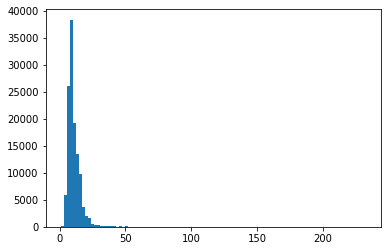

In [5]:
plt.hist([len(s) for s in train_drug_records], bins=100)
plt.show() # length of drug records

In [6]:
max_drug_len = 50 # value based on observation of the plot

unique_words_list = list(unique_words)
unique_words_list.insert(0, 'ENDPAD')

n_unique_words_list = len(unique_words_list)

In [7]:
n_tags = len(TAGS)
tag_to_indexes = {t: i for i, t in enumerate(TAGS)}

In [8]:
y_train = [[tag_to_indexes[word[1]] for word in drug_record] for drug_record in train_drug_records]
y_train = pad_sequences(maxlen=max_drug_len, sequences=y_train, padding="post", value=tag_to_indexes["O"])
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]
y_train = np.array(y_train)

In [9]:
word_to_indexes = {word: i for i, word in enumerate(unique_words_list)}

In [10]:
x_train = [[word_to_indexes[word[0]] for word in drug_record] for drug_record in train_drug_records]
x_train = pad_sequences(maxlen=max_drug_len, sequences=x_train, padding="post", value=word_to_indexes["ENDPAD"])

Prepare evaluation data

In [11]:
eval_data = get_data(TRAINING_DATASET_PATH)

eval_drug_records = DrugRecords(eval_data).get_drug_records()
eval_drug_records = eval_drug_records[1:]

In [12]:
x_val = [[word_to_indexes.get(word[0], n_unique_words_list) for word in drug_record] for drug_record in eval_drug_records]
x_val = pad_sequences(maxlen=max_drug_len, sequences=x_val, padding="post", value=word_to_indexes['ENDPAD'])

In [13]:
y_val = [[tag_to_indexes[word[1]] for word in drug_record] for drug_record in eval_drug_records]
y_val = pad_sequences(maxlen=max_drug_len, sequences=y_val, padding="post", value=tag_to_indexes["O"])
y_val = [to_categorical(i, num_classes=n_tags) for i in y_val]
y_val = np.array(y_val)

Set up hyperparameters

In [14]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_ACCURACY = 'accuracy'

In [15]:
# Creates a log file and writes training configuration

with tf.summary.create_file_writer(HPARAMS_PATH).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [16]:
def create_and_train_model(hparams):
    model = Sequential()
    model.add(Embedding(
        input_dim=n_unique_words_list + 1,
        output_dim=50,
        input_length=max_drug_len,
        mask_zero=True)
    )
    model.add(Bidirectional(LSTM(units=hparams[HP_NUM_UNITS], return_sequences=True)))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss="categorical_crossentropy",
      metrics=['accuracy'],
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

    model.fit(
        x_train,
        y_train,
        epochs=1,
        validation_data=(x_val, y_val),
        verbose=2,
        callbacks=callbacks
    )

    _, accuracy = model.evaluate(x_val, y_val)

    return accuracy

In [17]:
# This method creates directory for every run configuration and after each run it writes a summary into it

def run(run_dir, hyper_parameters):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hyper_parameters)  # record the values used in this trial
        accuracy = create_and_train_model(hyper_parameters)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [18]:
session_num = 0

# Print training process for every run

def run_and_print_progress(session_num, hyper_parameters):
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hyper_parameters[h] for h in hyper_parameters})
        run(HPARAMS_PATH + run_name, hyper_parameters)
        session_num += 1

Run hyperparameter tuning

In [ ]:
# This cell will start tuning and log process for every parameter configuration

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in tf.linspace(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 3):
        for optimizer in HP_OPTIMIZER.domain.values:
            hyper_parameters = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: float("%.2f"%float(dropout_rate)),
              HP_OPTIMIZER: optimizer
            }
            run_and_print_progress(session_num, hyper_parameters)

Load TensorBoard and visualize the tuning results in the form of various graphs

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir HPARAMS_PATH